In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
euro = pd.read_csv('./data/eurovision/cleaned_data.csv')
mino = pd.read_csv("./data/minorities/_eurostat_cleared_data.csv")
popu = pd.read_csv("./data/minorities/_population_data.csv")

In [3]:
THRESHOLD_CUT = 90 # only top 10% edges are counted as significant
Z_THRESHOLD = 1 # cca 0.933

## Significant minorities

In [4]:
sig_matrix = mino.merge(popu, left_on="citizen_name", right_on="country")
sig_matrix

,citizen_name,minority_name,head_count,country,population
0,Albania,Austria,6592.0,Albania,3107100
1,Albania,Belgium,3176.0,Albania,3107100
2,Albania,Bulgaria,564.0,Albania,3107100
3,Albania,Cyprus,388.0,Albania,3107100
4,Albania,Czech Republic,688.0,Albania,3107100
...,...,...,...,...,...
1268,United Kingdom,Slovenia,250.0,United Kingdom,68459055
1269,United Kingdom,Spain,379448.0,United Kingdom,68459055
1270,United Kingdom,Sweden,52248.0,United Kingdom,68459055
1271,United Kingdom,Switzerland,89412.0,United Kingdom,68459055


In [5]:
len(sig_matrix.dropna()) == len(sig_matrix)

True

In [6]:
sig_matrix['percent_pop'] = (sig_matrix['head_count'] / sig_matrix['population']) * 100
sig_matrix.head()

,citizen_name,minority_name,head_count,country,population,percent_pop
0,Albania,Austria,6592.0,Albania,3107100,0.212159
1,Albania,Belgium,3176.0,Albania,3107100,0.102218
2,Albania,Bulgaria,564.0,Albania,3107100,0.018152
3,Albania,Cyprus,388.0,Albania,3107100,0.012488
4,Albania,Czech Republic,688.0,Albania,3107100,0.022143


### Treshhold signinficance

In [7]:
threshold = np.percentile(sig_matrix["percent_pop"], THRESHOLD_CUT)

In [8]:
sig_matrix['significant_threshold'] = sig_matrix['percent_pop'] > threshold

In [9]:
sig_matrix.head()

,citizen_name,minority_name,head_count,country,population,percent_pop,significant_threshold
0,Albania,Austria,6592.0,Albania,3107100,0.212159,False
1,Albania,Belgium,3176.0,Albania,3107100,0.102218,False
2,Albania,Bulgaria,564.0,Albania,3107100,0.018152,False
3,Albania,Cyprus,388.0,Albania,3107100,0.012488,False
4,Albania,Czech Republic,688.0,Albania,3107100,0.022143,False


In [10]:
sig_matrix['significant_threshold'].value_counts()

significant_threshold
False    1145
True      128
Name: count, dtype: int64

### Z-score significance

In [11]:
mean_weight = sig_matrix["percent_pop"].mean()
std_dev_weight = sig_matrix["percent_pop"].std()
sig_matrix["z_score"] = (sig_matrix["percent_pop"] - mean_weight) / std_dev_weight

In [ ]:
# sig_matrix[sig_matrix['z_score'] == sig_matrix['z_score'].max()] -- some wierd things happening in albania...

In [12]:
sig_matrix['significant_zscore'] = sig_matrix['z_score'] > Z_THRESHOLD

In [13]:
sig_matrix.head()

,citizen_name,minority_name,head_count,country,population,percent_pop,significant_threshold,z_score,significant_zscore
0,Albania,Austria,6592.0,Albania,3107100,0.212159,False,-0.038115,False
1,Albania,Belgium,3176.0,Albania,3107100,0.102218,False,-0.091661,False
2,Albania,Bulgaria,564.0,Albania,3107100,0.018152,False,-0.132604,False
3,Albania,Cyprus,388.0,Albania,3107100,0.012488,False,-0.135363,False
4,Albania,Czech Republic,688.0,Albania,3107100,0.022143,False,-0.130660,False


In [14]:
sig_matrix['significant_zscore'].value_counts()

significant_zscore
False    1248
True       25
Name: count, dtype: int64

### Visualization

In [15]:
def vizualize(df, title = "Network of European Countries by Minority Percentage"):
    G = nx.DiGraph()
    for _, row in df.iterrows():
        G.add_edge(row["citizen_name"], row["minority_name"], weight=row["percent_pop"])
    pos = nx.spring_layout(G, seed=1001)
    # edge_labels = nx.get_edge_attributes(G, 'weight')
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=400, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=15)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title(title)
    plt.axis("off")
    plt.show()

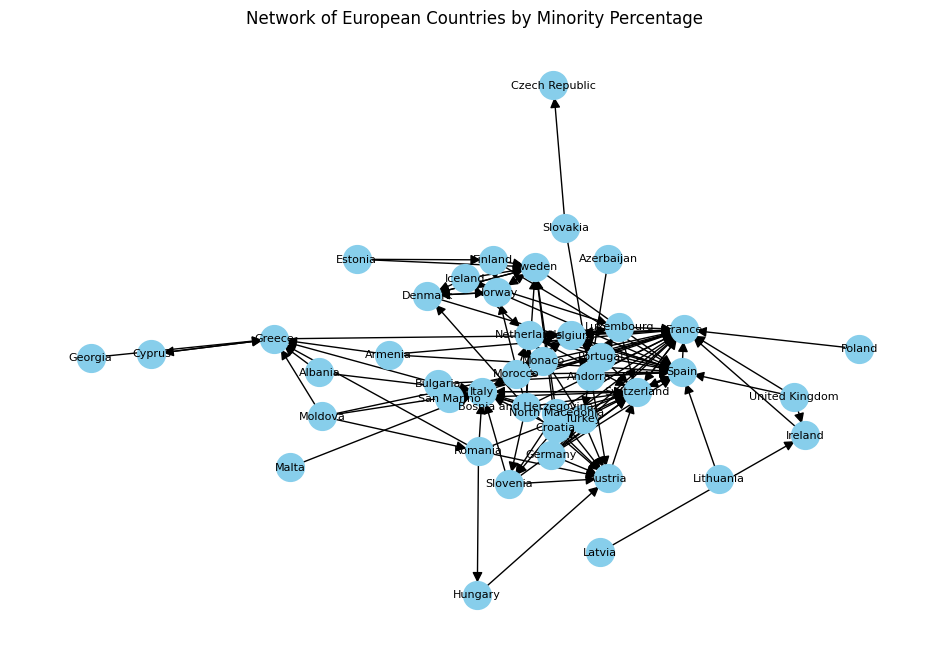

In [16]:
vizualize(sig_matrix[sig_matrix['significant_threshold']])

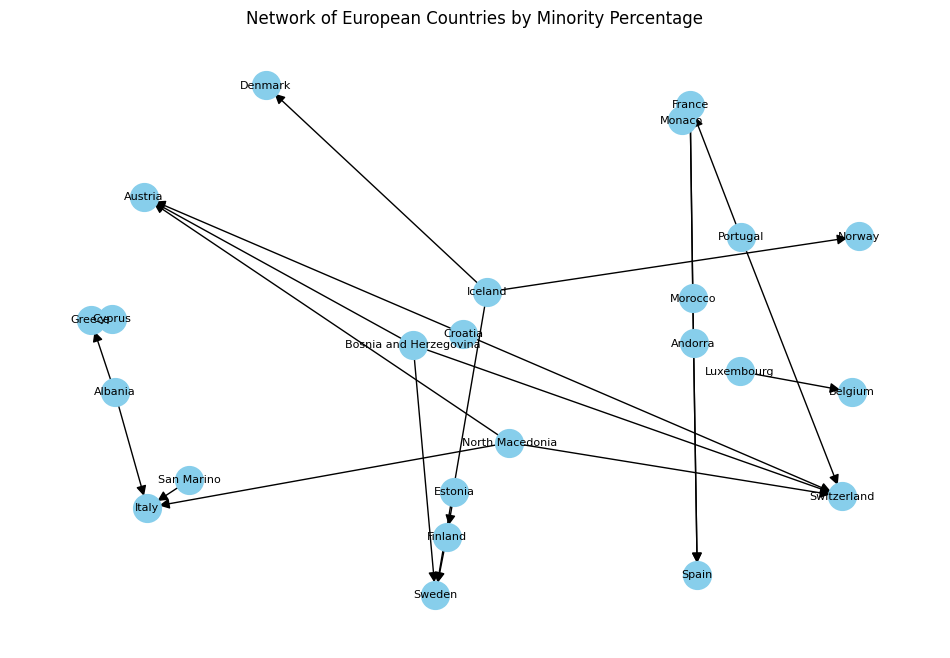

In [17]:
vizualize(sig_matrix[sig_matrix['significant_zscore']])

## Significant eurovision voting

In [18]:
euro.head()

,year,from_country,to_country,promil_scale
0,1957,Austria,Netherlands,6.0
1,1957,Austria,France,0.0
2,1957,Austria,Denmark,0.0
3,1957,Austria,Luxembourg,3.0
4,1957,Austria,Germany,0.0


### Avereged

In [19]:
avg = euro[['from_country', 'to_country', 'promil_scale']].groupby(['from_country', 'to_country']).sum().merge(euro[['from_country', 'to_country', 'year']].groupby(['from_country', 'to_country']).count(), on=['from_country', 'to_country']).rename(columns={'promil_scale': 'promil_sum', 'year': 'years_amount'}).reset_index()
avg

,from_country,to_country,promil_sum,years_amount
0,Albania,Albania,0.000000,11
1,Albania,Armenia,0.163144,12
2,Albania,Australia,0.228021,7
3,Albania,Austria,0.078170,8
4,Albania,Azerbaijan,0.364911,13
...,...,...,...,...
2087,United Kingdom,Sweden,7.486576,60
2088,United Kingdom,Switzerland,15.180929,50
2089,United Kingdom,Turkey,2.234798,33
2090,United Kingdom,Ukraine,0.589110,18


In [20]:
avg['standardized'] = avg['promil_sum'] / avg['years_amount']
avg = avg.drop(columns=['promil_sum', 'years_amount'])
avg

,from_country,to_country,standardized
0,Albania,Albania,0.000000
1,Albania,Armenia,0.013595
2,Albania,Australia,0.032574
3,Albania,Austria,0.009771
4,Albania,Azerbaijan,0.028070
...,...,...,...
2087,United Kingdom,Sweden,0.124776
2088,United Kingdom,Switzerland,0.303619
2089,United Kingdom,Turkey,0.067721
2090,United Kingdom,Ukraine,0.032728


#### Threshold signinficance

In [21]:
threshold = np.percentile(avg["standardized"], THRESHOLD_CUT)
avg['significant_threshold'] = avg['standardized'] > threshold
avg.head()

,from_country,to_country,standardized,significant_threshold
0,Albania,Albania,0.000000,False
1,Albania,Armenia,0.013595,False
2,Albania,Australia,0.032574,False
3,Albania,Austria,0.009771,False
4,Albania,Azerbaijan,0.028070,False


In [22]:
avg['significant_threshold'].value_counts()

significant_threshold
False    1882
True      210
Name: count, dtype: int64

#### Z-score significance

In [23]:
mean_weight = avg["standardized"].mean()
std_dev_weight = avg["standardized"].std()
avg["z_score"] = (avg["standardized"] - mean_weight) / std_dev_weight
avg['significant_zscore'] = avg['z_score'] > Z_THRESHOLD
avg.head()

,from_country,to_country,standardized,significant_threshold,z_score,significant_zscore
0,Albania,Albania,0.000000,False,-0.767509,False
1,Albania,Armenia,0.013595,False,-0.586227,False
2,Albania,Australia,0.032574,False,-0.333158,False
3,Albania,Austria,0.009771,False,-0.637218,False
4,Albania,Azerbaijan,0.028070,False,-0.393219,False


In [24]:
avg['significant_zscore'].value_counts()

significant_zscore
False    1871
True      221
Name: count, dtype: int64

### Year-over-year

In [34]:
yoy_dict = {}

In [36]:
for group, group_df in euro[['year', 'from_country', 'to_country', 'promil_scale']].groupby('year'):
    threshold = np.percentile(group_df["promil_scale"], THRESHOLD_CUT)
    group_df['significant_threshold'] = group_df['promil_scale'] > threshold
    mean_weight = group_df["promil_scale"].mean()
    std_dev_weight = group_df["promil_scale"].std()
    group_df["z_score"] = (group_df["promil_scale"] - mean_weight) / std_dev_weight
    group_df['significant_zscore'] = group_df['z_score'] > Z_THRESHOLD

    yoy_dict[group] = group_df

In [38]:
yoy_dict[2019]

,year,from_country,to_country,promil_scale,significant_threshold,z_score,significant_zscore
31392,2019,Albania,Netherlands,0.040253,False,0.422163,False
31393,2019,Albania,Italy,0.074755,False,1.465971,True
31394,2019,Albania,Russia,0.074755,False,1.465971,True
31395,2019,Albania,Switzerland,0.080506,False,1.639939,True
31396,2019,Albania,Sweden,0.034502,False,0.248194,False
...,...,...,...,...,...,...,...
32362,2019,United Kingdom,Spain,0.011501,False,-0.447678,False
32363,2019,United Kingdom,Israel,0.000000,False,-0.795614,False
32364,2019,United Kingdom,Belarus,0.000000,False,-0.795614,False
32365,2019,United Kingdom,Germany,0.000000,False,-0.795614,False


## Significance graphs comparison